In [50]:
%autoreload 2
%matplotlib inline

In [51]:
from __future__ import division

In [52]:
import pandas as pd
from astropy.io import fits

In [53]:
from astropy.coordinates import SkyCoord

In [54]:
import astropy.wcs.wcs as wcs
import matplotlib.pyplot as plt

In [55]:
from collections import OrderedDict
from DataScienceToolBox import preprocessing as prep

In [56]:
from preprocess_data import calculate_source_count_per_sq_arcmin

In [57]:
from IPython.display import Image

# Initialize data directory

In [58]:
path = "../../Data/"
dataPath = path + "Subaru_data/"

## load combined cat

In [59]:
df = pd.read_hdf(dataPath + "combined_cat.h5", 
                 "sources_with_specz_df")

In [60]:
spec_objs = ~np.isnan(df.spec_quality)
spec_df = df[spec_objs]

## Location of bright star?

In [61]:
bands = [k for k in df.keys() if "_MAG_" in k]

In [62]:
brightstar = df["Iband_MAG_ISO"].argmin()

In [63]:
df[bands].ix[brightstar]

Gband_MAG_APER    17.645307
Gband_MAG_AUTO    13.251150
Gband_MAG_ISO     13.231318
Iband_MAG_APER    23.161827
Iband_MAG_AUTO    13.089727
Iband_MAG_ISO     13.043600
Rband_MAG_APER    19.364254
Rband_MAG_AUTO    13.189942
Rband_MAG_ISO     13.148773
Name: 72153, dtype: float64

In [64]:
star_WCS = (df.loc[brightstar].RA, df.loc[brightstar].DEC)

approximately true 

# Signal to noise cut

In [65]:
for i in ["R", "G", "I"]:
    for bandtype in ["ISO", "AUTO", "APER"]: 
        SNRkey = "{0}band_{1}_SNR".format(i, bandtype)
        bandkey = "{0}band_MAG_{1}".format(i, bandtype)
        banderrkey = "{0}band_MAGERR_{1}".format(i, bandtype)
        df[SNRkey] = \
            np.abs(df[bandkey] / df[banderrkey])

# Subaru data cuts

5 $\sigma$ limiting magnitude of this Subaru catalog ...

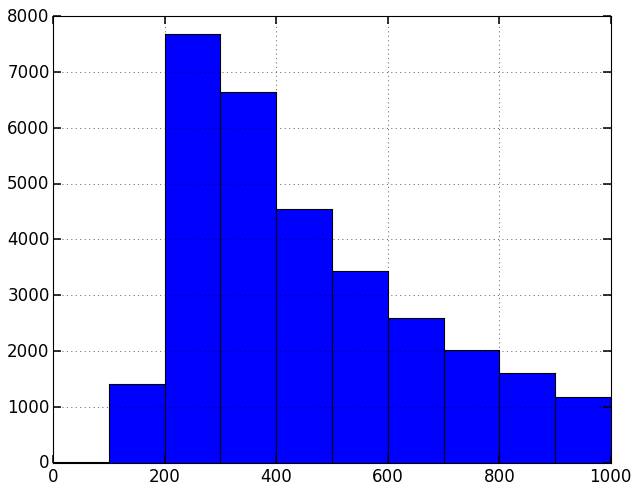

In [66]:
df["Rband_ISO_SNR"].hist(range= (0, 1000))

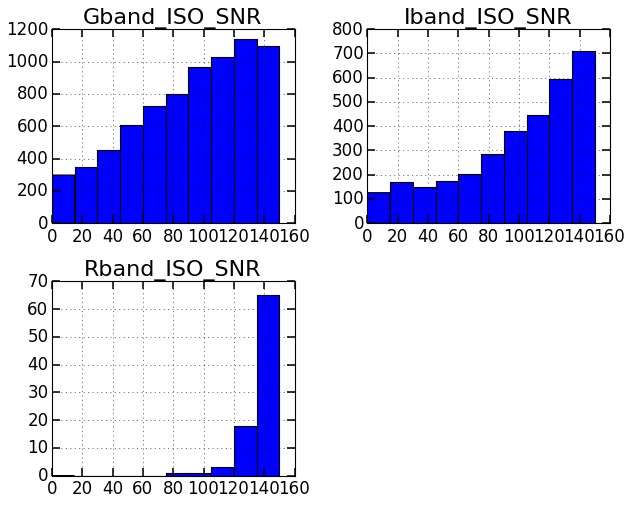

In [67]:
keys = ["Rband_ISO_SNR", "Iband_ISO_SNR", "Gband_ISO_SNR"] 
_ = df[keys].hist(range=(0, 150))

# come up with cuts for the shape catalog 

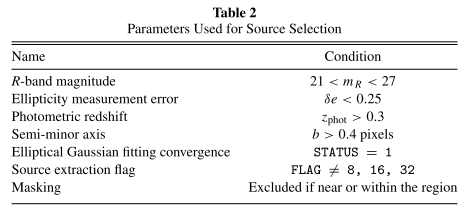

In [68]:
Image("./cut_range.png")  # from Jee 2013 Cosmic Shear paper

In [69]:
# format is key: (lower_bound, upperbound) 
# bounds are inclusive
accepted_range = {"Rband_MAG_ISO": (21, 25),
                  "Rband_MAG_AUTO": (21, 25),
                  "DE": (0, 0.25),
                  "Rband_B_IMAGE": (0.4, None),
                  "Iband_CLASS_STAR": (None, 0.6),
                  "Iband_FLUX_RADIUS": (2.3, None),
                  "Iband_ISO_SNR": (5, None),
                  "Iband_AUTO_SNR": (5, None),
                  "Iband_APER_SNR": (5, None)
                 }
accepted_cat = {"STATUS": 1}
rej_cat = {k: (8, 16, 32) for k in df.keys() if "FLAG" in k}


In [70]:
mask = prep.process_cuts(df, arange=accepted_range,
                  accept_cat=accepted_cat,
                  categorical_cuts=rej_cat,
                  verbose=True)

accepted obs with Rband_MAG_ISO_low >= 21 is 40825, 95.48% remaining
accepted obs with  Rband_MAG_ISO_up <= 25 is 14641, 34.24% remaining
accepted obs with Iband_APER_SNR_low >= 5 is 42046, 98.33% remaining
accepted obs with  Iband_CLASS_STAR_up <= 0.6 is 37109, 86.79% remaining
accepted obs with Rband_MAG_AUTO_low >= 21 is 40672, 95.12% remaining
accepted obs with  Rband_MAG_AUTO_up <= 25 is 16721, 39.11% remaining
accepted obs with Rband_B_IMAGE_low >= 0.4 is 42732, 99.94% remaining
accepted obs with Iband_ISO_SNR_low >= 5 is 42111, 98.49% remaining
accepted obs with Iband_FLUX_RADIUS_low >= 2.3 is 26078, 60.99% remaining
accepted obs with DE_low >= 0 is 42735, 99.95% remaining
accepted obs with  DE_up <= 0.25 is 21412, 50.08% remaining
accepted obs with Iband_AUTO_SNR_low >= 5 is 41760, 97.67% remaining
obs only accepting STATUS == 1 is 35189, 82.30% remaining
obs after cutting Rband_FLAGS != (8, 16, 32) is 42693, 99.85% remaining
obs after cutting Iband_FLAGS != (8, 16, 32) is 4260

In [71]:
star_class_keys = [u"{}band_CLASS_STAR".format(k) 
                   for k in ["I", "G", "R"]]
star_mask = df[star_class_keys] > 0.6
semiminor_key = [k for k in df.keys() if "B_IMAGE" in k]
semiminor_mask = df[semiminor_key] < 0.4

# Visualize different cuts

In [72]:
spec_stars = df.spec_quality == 4
np.sum(spec_stars)

349

In [73]:
df.shape

(42758, 131)

In [74]:
spec_gal = spec_df.spec_quality > 0
spec_stars = spec_df.spec_quality == -1

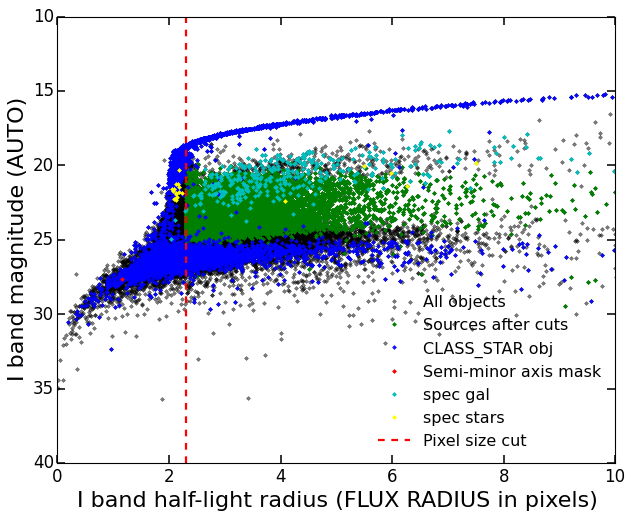

In [76]:
plt.plot(df["Iband_FLUX_RADIUS"],
         df["Iband_MAG_AUTO"],
         'k.', alpha=.5, label="All objects")
plt.plot(df["Iband_FLUX_RADIUS"][mask],
         df["Iband_MAG_AUTO"][mask],
         'g.', label="Sources after cuts")

# SEXtractor actually nails the stellar locus
plt.plot(df["Iband_FLUX_RADIUS"][star_mask["Iband_CLASS_STAR"]],
         df["Iband_MAG_AUTO"][star_mask["Iband_CLASS_STAR"]],
         'b.', alpha=.9, label="CLASS_STAR obj")
plt.plot(df["Iband_FLUX_RADIUS"][semiminor_mask["Iband_B_IMAGE"]],
         df["Iband_MAG_AUTO"][semiminor_mask["Iband_B_IMAGE"]],
         'r.', label="Semi-minor axis mask")

plt.plot(spec_df[spec_gal].Iband_FLUX_RADIUS,
         spec_df[spec_gal].Iband_MAG_AUTO, 
         "c.", label="spec gal")

plt.plot(spec_df[spec_stars].Iband_FLUX_RADIUS,
         spec_df[spec_stars].Iband_MAG_AUTO, 
         ".", color='yellow', label="spec stars")

plt.axvline(2.3, color='r', ls="--", lw=2, label="Pixel size cut")
plt.xlim(0, 10)
plt.ylim(plt.ylim()[::-1])
plt.legend(loc='best')
plt.ylabel("I band magnitude (AUTO)")
plt.xlabel("I band half-light radius (FLUX RADIUS in pixels)")
plt.savefig("../../Paper/figures/drafts/" + "IbandVshalflightRadius.eps",
            bbox_inches="tight")

# Determining star halflight radius cutoff

In [23]:
starlocus_mask = np.logical_and(df["Iband_MAG_AUTO"] <= 19,
                                star_mask["Iband_CLASS_STAR"])
FLUX_RADIUS_lower_cutoff = \
    df["Iband_FLUX_RADIUS"][starlocus_mask].ix[68119]

In [24]:
print FLUX_RADIUS_lower_cutoff

2.24178814888


(35.0, 10.0)

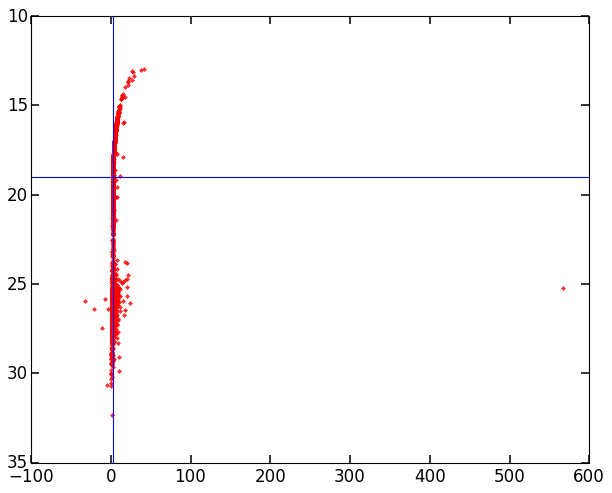

In [25]:
plt.plot(df["Iband_FLUX_RADIUS"][star_mask["Iband_CLASS_STAR"]],
         df["Iband_MAG_AUTO"][star_mask["Iband_CLASS_STAR"]],
         'r.', alpha=.8, label="CLASS_STAR obj")
plt.axvline(FLUX_RADIUS_lower_cutoff)
plt.axhline(19)
plt.ylim(plt.ylim()[::-1])

In [26]:
df = df[mask]

In [27]:
df.to_hdf(dataPath + "combined_cat.h5",
          "sources")

## See spatial distribution of possible sources

In [28]:
print star_WCS

(267.87493896484375, 44.796314239501953)


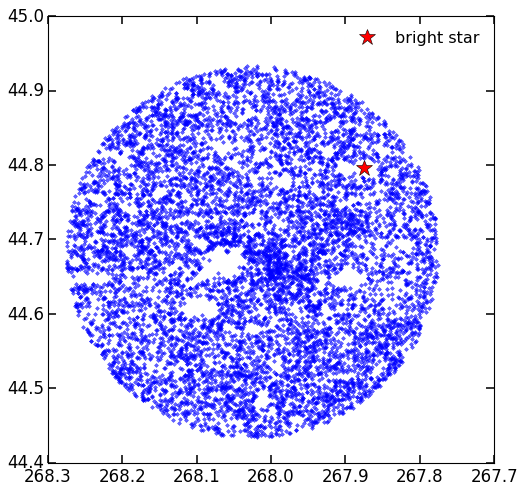

In [29]:
plt.axes().set_aspect('equal')
plt.plot(df.Rband_X_WORLD, 
         df.Rband_Y_WORLD, '.', alpha=0.6)
plt.plot(star_WCS[0],
         star_WCS[1],
         "r*", ms=15, label="bright star")
plt.xlim(plt.xlim()[::-1])
xticks = plt.xticks()
plt.xticks(xticks[0], [str(tick) for tick in xticks[0]])
plt.legend(loc='best')

# source count 

In [30]:
lower_left_wcs = ["17h52m40s", "44d35m30s"]
upper_right_wcs = ["17h51m40s", "44d45m30s"]

In [31]:
calculate_source_count_per_sq_arcmin(lower_left_wcs, 
                                     upper_right_wcs, df.shape[0])

60.353333333334191